In [1]:
import os
import getpass
import numpy as np
import pandas as pd
from time import time
from functools import reduce
import matplotlib.pyplot as plt

# Sklearn
from sklearn.impute import SimpleImputer

from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Own Liberay
import PCR_model as model

# PCR - Principal component regression

**How to read this notebook:**

---

1. **Data processing**  
We load and prepare the dataset for modeling, including setting the target (inflation) and explanatory variables.  
---

2. **Forecast**  
We apply the PCR model to forecast inflation *h* months ahead from a given point in time (*last_observation_date*), using a fixed training window of *window_length* months.  

    2.1. **Variable Selection**  
    After fitting, we examine the non-zero coefficients to identify which explanatory variables drive the forecast at horizon *h*.

---

3. **Rolling Forecasts**  
We implement a multi-horizon rolling window approach that mimics real-world forecasting. At each time point (e.g., January 2023), the model is trained on the most recent 96 months of data and used to forecast inflation 1 to 12 months ahead.  
The window then rolls forward by one month, and the process repeats.  
This procedure follows the real-time setup from Garcia et al. (2017).

---

4. **Model Evaluation**

     4.1. **Forecast Accuracy by Horizon** \
      We report standard metrics:
        - Mean Absolute Error (MAE)
        - Root Mean Squared Error (RMSE)  
    for each forecast horizon using the rolling forecasts.

    4.2. **Forecast Details (Example: 1-month ahead)**  
    We present detailed forecast vs. actual values, forecast errors, and squared errors for a selected horizon (e.g. *h* = 1).


## 1. Data processing

In [5]:
# Gå et niveau op og naviger til mappen "Data"
os.chdir('../Data')

In [6]:
# Load dataset and set 'Date' as index
file_path = 'merged_dataset.csv'
df = pd.read_csv(file_path, sep=';', parse_dates=['Date'])
df.set_index('Date', inplace=True)

# Display dataset shape
print("Dataset shape:", df.shape)  # (rows, columns)

Dataset shape: (156, 276)


In [7]:
# Split into target (y) and features (X)
y = df.iloc[:, 0]   # First column = inflation (target variable)
X = df.iloc[:, 1:]  # Remaining columns = explanatory variables

# Print shapes
print("y shape:", y.shape)
print("X shape:", X.shape)

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

y shape: (156,)
X shape: (156, 275)


# 2. Forecast

The approach follows a **direct multi-horizon setup**, where a separate PCR model is estimated for each forecast horizon ( \( h = 1, \dots, 12 \) ). Each model is trained on a fixed-length rolling window (e.g., 30 months), ending at the specified `last_observation_date`.

Unlike regular regression, PCR first reduces the dimensionality of the predictor space using **Principal Component Analysis (PCA)** before fitting a linear model. The number of components is automatically selected to retain a given share of the total variance, controlled by the `variance_threshold` parameter (e.g., 0.999 for 99.9% explained variance).

By setting `return_models=True`, we retain access to the fitted models at each horizon, allowing us to analyze which original variables drive the forecasts via the PCA transformation.


In [10]:
df_pcr_rolling_forecast, pcr_models  = model.pcr_forecaster(
    X=X, 
    y=y, 
    forecast_horizon = 12, 
    last_observation_date="2023-12-01", 
    scaler=scaler, 
    window_length=30,
    variance_threshold=0.999, 
    verbose=True,
    return_models = True
)


=== Horizon h=0 ===
Explained variance (k=29): 100.00%
Training obs: 30 | Components used: 29

=== Horizon h=1 ===
Explained variance (k=28): 100.00%
Training obs: 29 | Components used: 28

=== Horizon h=2 ===
Explained variance (k=27): 100.00%
Training obs: 28 | Components used: 27

=== Horizon h=3 ===
Explained variance (k=26): 100.00%
Training obs: 27 | Components used: 26

=== Horizon h=4 ===
Explained variance (k=25): 100.00%
Training obs: 26 | Components used: 25

=== Horizon h=5 ===
Explained variance (k=24): 100.00%
Training obs: 25 | Components used: 24

=== Horizon h=6 ===
Explained variance (k=23): 100.00%
Training obs: 24 | Components used: 23

=== Horizon h=7 ===
Explained variance (k=22): 100.00%
Training obs: 23 | Components used: 22

=== Horizon h=8 ===
Explained variance (k=21): 100.00%
Training obs: 22 | Components used: 21

=== Horizon h=9 ===
Explained variance (k=20): 100.00%
Training obs: 21 | Components used: 20

=== Horizon h=10 ===
Explained variance (k=19): 1

In [11]:
df_inflation = pd.merge(
    df_pcr_rolling_forecast.set_index("Date"),
    y,
    left_index=True,
    right_index=True,
    how="left"
)

In [12]:
df_inflation

,Inflation forecast,Horizon,Inflation
Date,,,
2024-01-01,0.690000,0,1.203
2024-02-01,-0.516693,1,0.766
2024-03-01,0.451812,2,0.938
2024-04-01,1.704164,3,0.765
2024-05-01,1.626808,4,2.155
2024-06-01,1.694415,5,1.804
2024-07-01,1.529731,6,1.097
2024-08-01,2.229413,7,1.359
2024-09-01,2.471342,8,1.278


### Annual Average Inflation Forecast vs. Actual
To evaluate the model's overall performance for a year, we compare the average predicted inflation to the actual average inflation over the same period. The difference is reported in percentage points (pp) as a simple measure of forecast bias.


In [14]:
forecast_avg = df_inflation["Inflation forecast"].mean()
actual_avg = df_inflation["Inflation"].mean()
error = forecast_avg - actual_avg

print("=== 2024 ===")
print(f"Forecasted avg. inflation: {forecast_avg:.3f}")
print(f"Actual avg. inflation:     {actual_avg:.3f}")
print(f"Forecast error (pp):       {error:.3f}")

=== 2024 ===
Forecasted avg. inflation: 1.707
Actual avg. inflation:     1.374
Forecast error (pp):       0.334


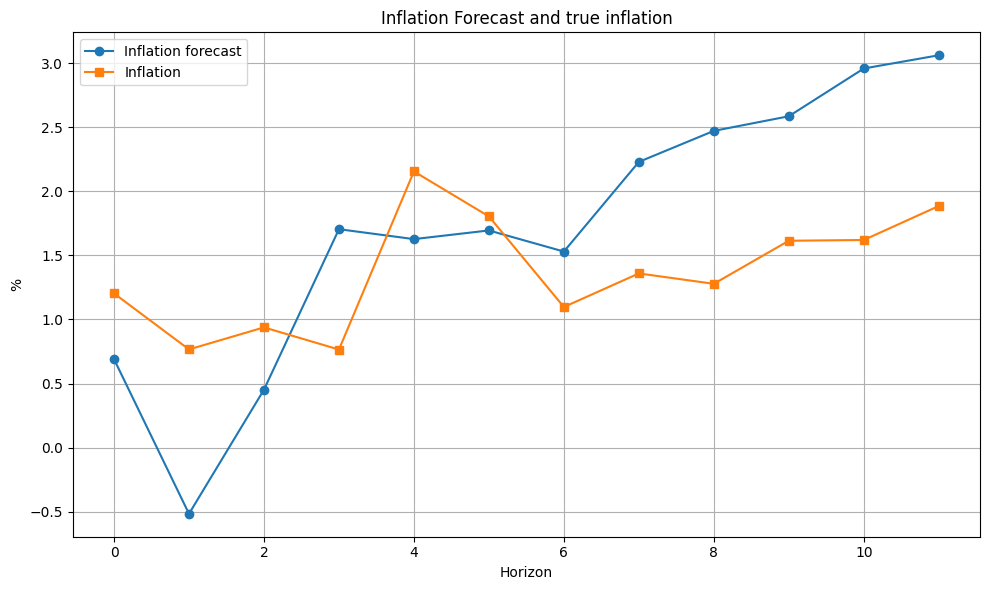

In [15]:
plt.figure(figsize=(10, 6))
plt.plot(df_inflation['Horizon'], df_inflation['Inflation forecast'], marker='o', label='Inflation forecast')
plt.plot(df_inflation['Horizon'], df_inflation['Inflation'], marker='s', label='Inflation')
plt.xlabel('Horizon')
plt.ylabel('%')
plt.title('Inflation Forecast and true inflation')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## 2.1. Variable Selection  

In PCR, the model first transforms the original predictors into principal components (PCs) and then runs a linear regression on those PCs. This makes it harder to directly see which original features matter most.

To recover feature importance:

1. For each forecast horizon, extract the PCA loadings and regression coefficients.
2. Reconstruct the importance of each original feature by multiplying PC loadings with the regression weights.
3. Sum the absolute values of these reconstructed weights across horizons.
4. Count how often each feature contributes (i.e., has non-zero weight).

This gives a simple measure of how influential each feature is across all horizons.


In [18]:
from collections import defaultdict, Counter

# Two measures: how often a feature contributes, and total absolute weight
feature_freq = Counter()
feature_weight = defaultdict(float)

for h, model_i in pcr_models.items():
    pca = model_i.named_steps["pca"]
    reg = model_i.named_steps["reg"]

    # PCA components: shape (n_components, n_features)
    components = pca.components_

    # Regression coefficients on the principal components (length = n_components)
    reg_coefs = reg.coef_

    # Reconstruct feature-level coefficients:
    # coef_feature_f = sum over k (loading_{kf} * beta_k)
    original_coefs = np.dot(reg_coefs, components)

    for f, c in zip(X.columns, original_coefs):
        feature_freq[f] += 1
        feature_weight[f] += abs(c)

# Combine results in a DataFrame
summary_df = pd.DataFrame({
    "Frequency": pd.Series(feature_freq),
    "Total_Abs_Weight": pd.Series(feature_weight)
})

# Sort by total weight
summary_df = summary_df.sort_values("Total_Abs_Weight", ascending=False)

# Display top 15 features
summary_df.head(15)


,Frequency,Total_Abs_Weight
"Priser om et år, sammenlignet med i dag",12,1.391407
PPI_domestic_32 Anden fremstillingsvirksomhed,12,1.125963
PPI_domestic_10 Fremstilling af fødevarer,12,1.087088
PPI_import_24 Fremstilling af metal,12,1.076039
inflation_lag12,12,1.033263
inflation_lag4,12,1.030997
Vielser i alt,12,1.002889
inflation_lag11,12,0.988008
"PPI_domestic_29 Fremstilling af motorkøretøjer, påhængsvogne og sættevogne",12,0.984927
PPI_domestic_15 Fremstilling af læder og lædervarer,12,0.978681


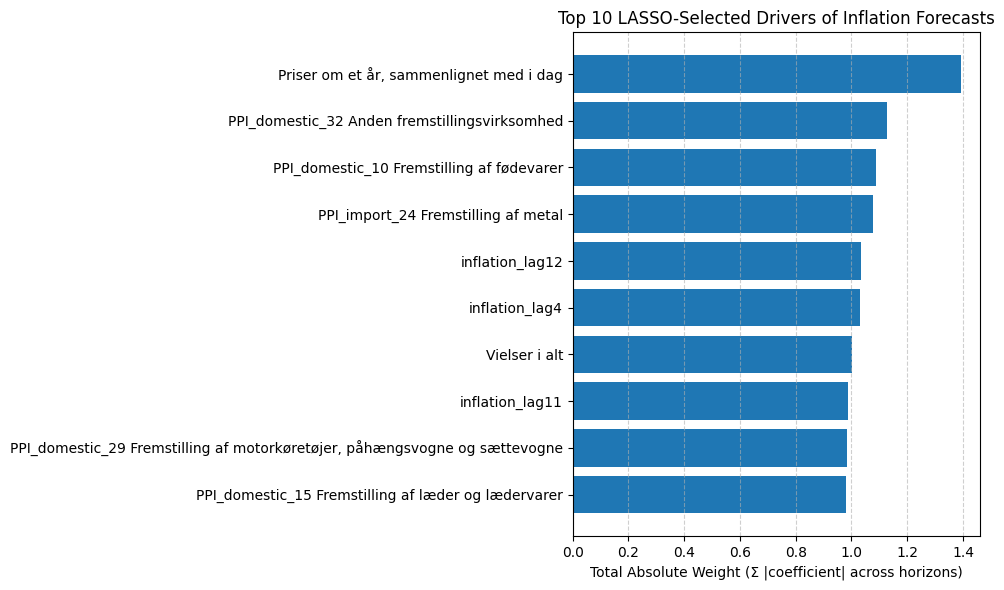

In [19]:
# Top 10 most importent variabler
top_features = summary_df.sort_values("Total_Abs_Weight", ascending=False).head(10)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(top_features.index[::-1], top_features["Total_Abs_Weight"][::-1])
plt.xlabel("Total Absolute Weight (Σ |coefficient| across horizons)")
plt.title("Top 10 LASSO-Selected Drivers of Inflation Forecasts")
plt.grid(axis="x", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

# 3. Rolling Forecasts  
### Real-Time Multi-Horizon Predictions


The function simulates how forecasts would be made in real time, one month at a time.

At each point in the forecast period, it:

1. Collects only data available up to that month (real-time assumption).
2. Fits a forecasting model using the most recent `window_length` months.
3. Generates forecasts for multiple horizons (e.g., 1 to 12 months ahead).
4. Repeats the process for every month from `start_date` to `end_date`.

The result is a rolling panel of forecasts that mimics how a forecaster would operate in practice, using only information available at the time each prediction is made.


In [22]:
%%time
forecast_results = model.run_rolling_forecast(
    X=X, 
    y=y, 
    forecast_horizon=12, 
    start_date="2023-01-01", 
    end_date="2024-12-01", 
    window_length=72
)

CPU times: user 10.8 s, sys: 44.1 s, total: 54.9 s
Wall time: 6.05 s


# 4. Model Evaluation
## 4.1 Forecast Accuracy by Horizon

To assess how forecast performance varies across time horizons, we compute standard accuracy metrics:

- **MAE** (Mean Absolute Error): Average absolute deviation from actual inflation
- **RMSE** (Root Mean Squared Error): Penalizes large errors more heavily
- **N_obs**: Number of evaluation points for each horizon

The table below reports these metrics for each horizon \( h = 1, .. , 12 \), where horizon 0 corresponds to 1-month-ahead forecasts and horizon 11 to 12-months-ahead forecasts.

This gives a sense of how quickly forecast quality deteriorates as the prediction horizon increases.

In [25]:
eval_df, merged_df = model.evaluate_forecasts(forecast_results, y)
eval_df

,Horizon,MAE,RMSE,N_obs
0,0,0.676102,0.897290,23
1,1,1.347133,1.738011,22
2,2,1.417987,2.016699,21
3,3,1.636062,2.340958,20
4,4,1.579064,2.343549,19
5,5,1.625465,2.317284,18
6,6,1.883663,2.806372,17
7,7,2.265048,3.228369,16
8,8,2.209492,3.506294,15
9,9,2.196128,3.465828,14


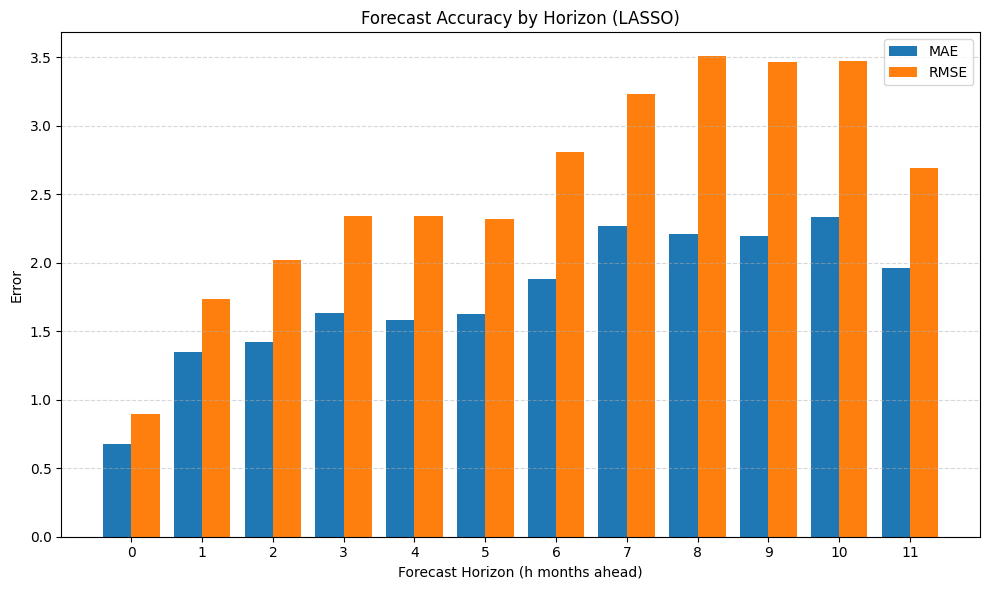

In [26]:
plt.figure(figsize=(10, 6))
h = eval_df["Horizon"]

# Plot MAE og RMSE som søjler
bar_width = 0.4
plt.bar(h - bar_width/2, eval_df["MAE"], width=bar_width, label="MAE")
plt.bar(h + bar_width/2, eval_df["RMSE"], width=bar_width, label="RMSE")

plt.xlabel("Forecast Horizon (h months ahead)")
plt.ylabel("Error")
plt.title("Forecast Accuracy by Horizon (LASSO)")
plt.xticks(h)
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


## 4.2. Forecast Details (Example: 1-month ahead)

In [28]:
h1 = merged_df[merged_df["Horizon"] == 0]
h1

,Date,Inflation forecast,Horizon,Forecast_made_in,y_true,error,abs_error,squared_error
0,2023-02-01,7.720951,0,2023-01-01,7.601,0.119951,0.119951,0.014388
12,2023-03-01,7.663360,0,2023-02-01,6.733,0.930360,0.930360,0.865569
24,2023-04-01,6.831673,0,2023-03-01,5.282,1.549673,1.549673,2.401485
36,2023-05-01,5.240397,0,2023-04-01,2.928,2.312397,2.312397,5.347181
48,2023-06-01,3.320515,0,2023-05-01,2.465,0.855515,0.855515,0.731907
60,2023-07-01,2.437075,0,2023-06-01,3.133,-0.695925,0.695925,0.484312
72,2023-08-01,3.156191,0,2023-07-01,2.437,0.719191,0.719191,0.517236
84,2023-09-01,2.444522,0,2023-08-01,0.859,1.585522,1.585522,2.513880
96,2023-10-01,1.318328,0,2023-09-01,0.085,1.233328,1.233328,1.521099
108,2023-11-01,0.027530,0,2023-10-01,0.600,-0.572470,0.572470,0.327722


#### Annualized Inflation Comparison

To evaluate the forecast model over longer horizons, we compute the average annualized inflation for two distinct 12-month periods. 
For each period, we calculate the average of the forecasted monthly inflation and compare it to the average of the actual inflation.

This gives a sense of how well the model tracks long-run inflation dynamics over time.

In [30]:
# Definér perioder og årstal
periods = {
    "2023": slice(0, 12),
    "2024": slice(12, 24)
}

# Beregn og print gennemsnitlig inflation per år
for year, s in periods.items():
    forecast_avg = h1["Inflation forecast"].iloc[s].mean()
    actual_avg = h1["y_true"].iloc[s].mean()

    print(f"\n=== {year} ===")
    print(f"Forecasted avg. inflation: {forecast_avg:.3f}")
    print(f"Actual avg. inflation:     {actual_avg:.3f}")
    print(f"Forecast error (pp):       {forecast_avg - actual_avg:.3f}")


=== 2023 ===
Forecasted avg. inflation: 3.417
Actual avg. inflation:     2.835
Forecast error (pp):       0.582

=== 2024 ===
Forecasted avg. inflation: 1.354
Actual avg. inflation:     1.389
Forecast error (pp):       -0.035


#### Forecast Error Over Time (h = 1)

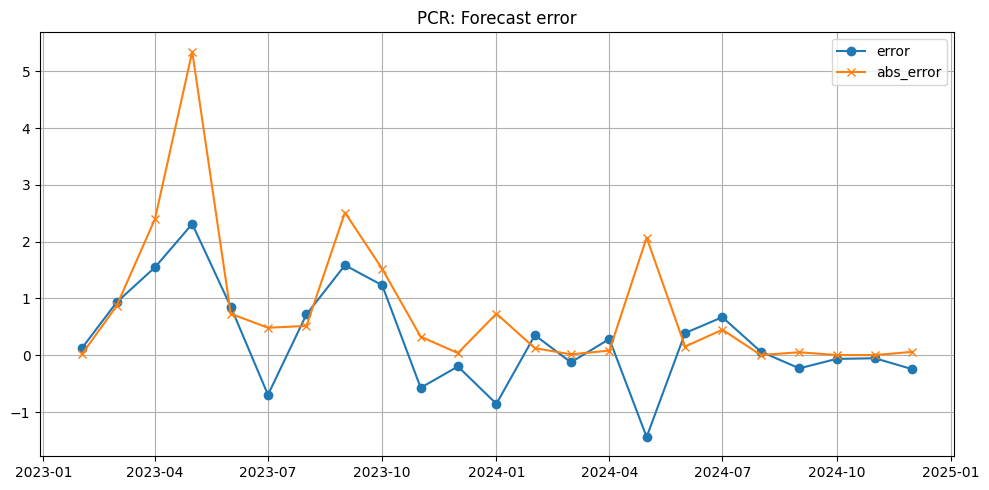

In [32]:
plt.figure(figsize=(10, 5))
plt.plot(h1["Date"], h1["error"], label="error", marker="o")
plt.plot(h1["Date"], h1["squared_error"], label="abs_error", marker="x")
plt.legend()
plt.title("PCR: Forecast error")
plt.grid(True)
plt.tight_layout()
plt.show()

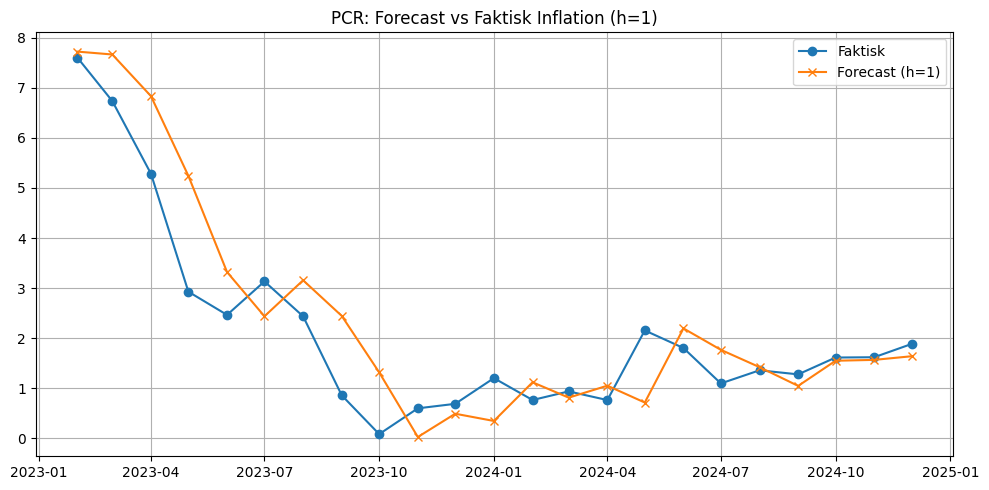

In [33]:
plt.figure(figsize=(10, 5))
plt.plot(h1["Date"], h1["y_true"], label="Faktisk", marker="o")
plt.plot(h1["Date"], h1["Inflation forecast"], label="Forecast (h=1)", marker="x")
plt.legend()
plt.title("PCR: Forecast vs Faktisk Inflation (h=1)")
plt.grid(True)
plt.tight_layout()
plt.show()